## Imports, Settings, & Functions

In [1]:
import cv2
import PIL.Image as Image
import os
from scipy.io import loadmat
from scipy.io.matlab import mat_struct
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
root_dir = "/home/linux-pc/gh/projects/NeuralNexus/New-Features/Thought-to-Image/V1-Visual-Cortex-Visualization"
data_root_dir = root_dir + "/data/crcns-pvc1/crcns-ringach-data/"
movie_root_dir = "movie_frames/movie000_000.images/"
current_movie = "movie000_000_000.jpeg"
neuro_root_dir = "neurodata/ac1/"
current_neuro_data = "ac1_u004_000.mat"

In [3]:
movie_frame_path = '/home/linux-pc/gh/projects/NeuralNexus/New-Features/Thought-to-Image/V1-Visual-Cortex-Visualization/data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_000.jpeg'

In [4]:
def matlab_to_python(obj):
    """Recursively convert MATLAB structs and cell arrays to Python dicts/lists."""
    if isinstance(obj, mat_struct):
        return {field: matlab_to_python(getattr(obj, field)) for field in obj._fieldnames}
    elif isinstance(obj, np.ndarray):
        # Handle MATLAB cell arrays
        if obj.dtype == object:
            return [matlab_to_python(el) for el in obj.flat]
        else:
            return obj
    elif isinstance(obj, list):
        return [matlab_to_python(el) for el in obj]
    else:
        return obj


In [71]:
def analyze_waveform(pepANA_clean, condition=0, electrode=0, verbose=False):
    """
    Analyze SVD of waveforms from a specific condition and electrode in pepANA.

    Parameters:
        pepANA_clean: dict - Unpacked MATLAB structure from loadmat
        condition: int - Index of the condition (0-based)
        electrode: int - Index of the electrode (0-based)
        verbose: bool - Whether to show plots

    Returns:
        signal_idx: np.ndarray - Indices of waveforms classified as signal
    """

    # Extract waveform matrix [time x waveforms]
    waveforms = pepANA_clean["listOfResults"][condition]["repeat"]["data"][electrode][1]
    waveforms = np.array(waveforms, dtype=np.float64)  # Ensure float precision

    # Perform SVD
    u, s, vT = np.linalg.svd(waveforms, full_matrices=False)  # vT: shape [n_waveforms, n_waveforms]

    # Projection into first 2 principal components
    projections = vT.T[:, :2]  # shape: [n_waveforms, 2]

    # Plot SVD projections
    if verbose:
        plt.figure(figsize=(8, 6))
        plt.scatter(projections[:, 0], projections[:, 1], s=10)
        plt.plot(0, 0, 'r.', markersize=25)
        plt.title(f"SVD Projection: Condition {condition+1}, Electrode {electrode+1}")
        plt.xlabel("1st Principal Component")
        plt.ylabel("2nd Principal Component")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Cluster using k-means on waveforms
    km = KMeans(n_clusters=2, random_state=0)
    cluster_labels = km.fit_predict(waveforms.T)  # waveforms.T: shape [n_waveforms x time]

    # Separate clusters
    idx1 = np.where(cluster_labels == 0)[0]
    idx2 = np.where(cluster_labels == 1)[0]

    # Compare total amplitude to identify signal vs noise
    mean1 = np.mean(waveforms[:, idx1], axis=1)
    mean2 = np.mean(waveforms[:, idx2], axis=1)

    amp1 = np.sum(np.abs(mean1))
    amp2 = np.sum(np.abs(mean2))

    if amp1 > amp2:
        signal_idx = idx1
        noise_idx = idx2
    else:
        signal_idx = idx2
        noise_idx = idx1

    # Detailed plotting if verbose
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.scatter(projections[noise_idx, 0], projections[noise_idx, 1], color='b', s=10, label="Noise")
        ax1.scatter(projections[signal_idx, 0], projections[signal_idx, 1], color='g', s=10, label="Signal")
        ax1.plot(0, 0, 'r.', markersize=25)
        ax1.set_title("SVD Clustering")
        ax1.set_xlabel("1st PC")
        ax1.set_ylabel("2nd PC")
        ax1.legend()
        ax1.grid(True)

        # Plot error bars of signal and noise mean traces
        timepoints = np.arange(waveforms.shape[0])
        signal_waveforms = waveforms[:, signal_idx].T
        noise_waveforms = waveforms[:, noise_idx].T

        ax2.errorbar(
            timepoints,
            np.mean(signal_waveforms, axis=0),
            yerr=np.std(signal_waveforms, axis=0),
            label="Signal", color='g'
        )
        ax2.errorbar(
            timepoints,
            np.mean(noise_waveforms, axis=0),
            yerr=np.std(noise_waveforms, axis=0),
            label="Noise", color='b'
        )
        ax2.set_xlim([0, 49])
        ax2.set_title("Mean Waveform with Std Dev")
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Amplitude")
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()
    else:
        noise_waveforms = waveforms[:, noise_idx].T

    return signal_idx, np.mean(noise_waveforms, axis=0)



In [6]:
def plot_signal_waveforms_aligned(pepANA_clean, condition, signal_idx, electrode=0, sampling_rate=30000.0):
    """
    Plot each waveform in `signal_idx` aligned to its actual time points.

    Parameters:
        pepANA_clean : dict
            MATLAB structure loaded via scipy.io.loadmat
        condition : int
            Index into the listOfResults (0-based)
        signal_idx : array-like
            Indices of signal-classified waveforms
        electrode : int
            Which electrode (0-based index into .data)
        sampling_rate : float
            Sampling rate in Hz (default 30 kHz)
    """

    arrival_times = pepANA_clean["listOfResults"][condition]["repeat"]["data"][electrode][0]  # shape: (N,)
    waveforms = pepANA_clean["listOfResults"][condition]["repeat"]["data"][electrode][1]       # shape: (48, N)

    # Constants
    waveform_length = waveforms.shape[0]                   # 48 samples
    time_step = 1.0 / sampling_rate                        # e.g., 1 / 30000 seconds

    plt.figure(figsize=(12, 8))

    for idx in signal_idx:
        t0 = arrival_times[idx]                            # starting time of spike
        waveform = waveforms[:, idx]
        t_waveform = t0 + np.arange(waveform_length) * time_step  # 48 time samples starting at t0

        plt.plot(t_waveform * 1000, waveform, alpha=0.4)   # convert to ms

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (int8 units)")
    plt.title(f"Signal-Aligned Waveforms (n={len(signal_idx)})")
    plt.grid(True)
    plt.tight_layout()

    plt.show()


In [77]:
def collect_mean_noise_waveforms_and_signal_indices(pepANA_clean, verbose=False):
    """This will collect all the mean noise waveforms to be used when a waveform is not detected from the stimulus in another electrode. 
    This will also return all indices of detected signals.

    Args:
        pepANA_clean (dict): This is the dict containing all 120 conditions and meta data for the trials.
    
    Returns:
        mean_noise_waveforms (np.ndarray): 16 x 48 mean-noise waveforms for a single condition.
        signal_idx_l (list): Each list index is an np.array of indices of detected signals for use 
            in the pepANA_clean["listOfResults"][0]["repeat"]["data"][electrode][1] for signal 
            and pepANA_clean["listOfResults"][0]["repeat"]["data"][electrode][0] for initial starting times.
    """
    mean_noise_waveforms = np.zeros((16,48))
    signal_idx_l = []

    for electrode in range(16):
        signal_indices, mean_noise_waveforms[electrode] = analyze_waveform(pepANA_clean, 0, electrode, verbose=verbose)
        signal_idx_l.append(signal_indices)
    return signal_idx_l, mean_noise_waveforms


In [42]:
def normalize_waveform(waveform):
    """
    Normalize a 16x48 waveform to zero mean and unit variance.
    """
    mean = waveform.mean()
    std = waveform.std()
    return (waveform - mean) / std


### Testing image data load

In [7]:
path = "../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_000.jpeg"

In [8]:
image = cv2.imread(path , cv2.IMREAD_COLOR)
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
image = Image.open(movie_frame_path)
image.show()

### Testing neural data load

In [10]:
neuro_data_path = os.path.join(data_root_dir, neuro_root_dir, current_neuro_data)
mat = loadmat(neuro_data_path, struct_as_record=False, squeeze_me=True)
pepANA = mat["pepANA"]
pepANA_clean = matlab_to_python(pepANA)

In [ ]:
# Total Number of Conditions
pepANA_clean["no_conditions"]

In [ ]:
# Arrival Times for electrodes in pepANA.electrode_list
pepANA_clean["listOfResults"][0]["repeat"]["data"][12]

In [ ]:
# Detected Waveforms at that time
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

In [ ]:
# Times since initial waveform is detected. (48 samples of waveform snippets)
# (Contains spikes and noise bc of low threshold 
# (1.6ms sampled at 30kHz at int8 precision)) 

pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0].shape

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][0]

In [ ]:
x = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][47])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract waveform data and spike times
waveforms = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1]  # (48, 573)
arrival_times = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]  # (573,)


In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0]

In [ ]:
# Parameters
n_waveforms = waveforms.shape[1]
n_samples = waveforms.shape[0]

In [ ]:
sampling_rate = 30_000  # Hz
offset = 200  # vertical spacing between waveforms
time_axis = np.arange(n_samples) / sampling_rate * 1_000  # in milliseconds (0–1.6 ms)

In [ ]:
n_waveforms

In [ ]:
waveform_t = (arrival_times[0] + np.arange(n_samples) / 30000)

In [ ]:
n_samples

In [ ]:
arrival_times[0]

In [ ]:
waveforms[:,0]

In [ ]:
waveforms.shape[1]

In [ ]:
t = 0

In [ ]:
t += 1
t = t % waveforms.shape[1]
waveform_t = (arrival_times[t] + np.arange(n_samples) / 30000)
plt.plot(waveform_t, waveforms[:,t])

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][0]

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][:, 0]

In [ ]:
plt.plot()

In [ ]:
573

## SVD of Waveforms

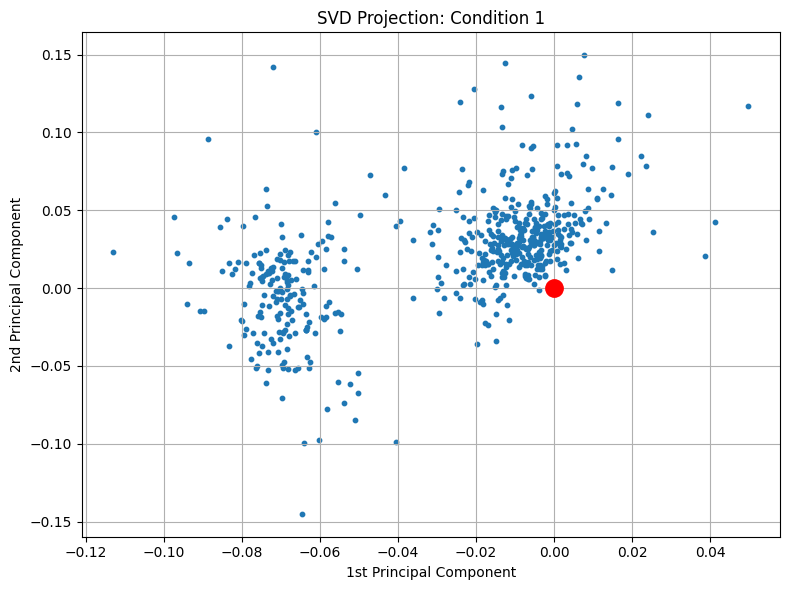

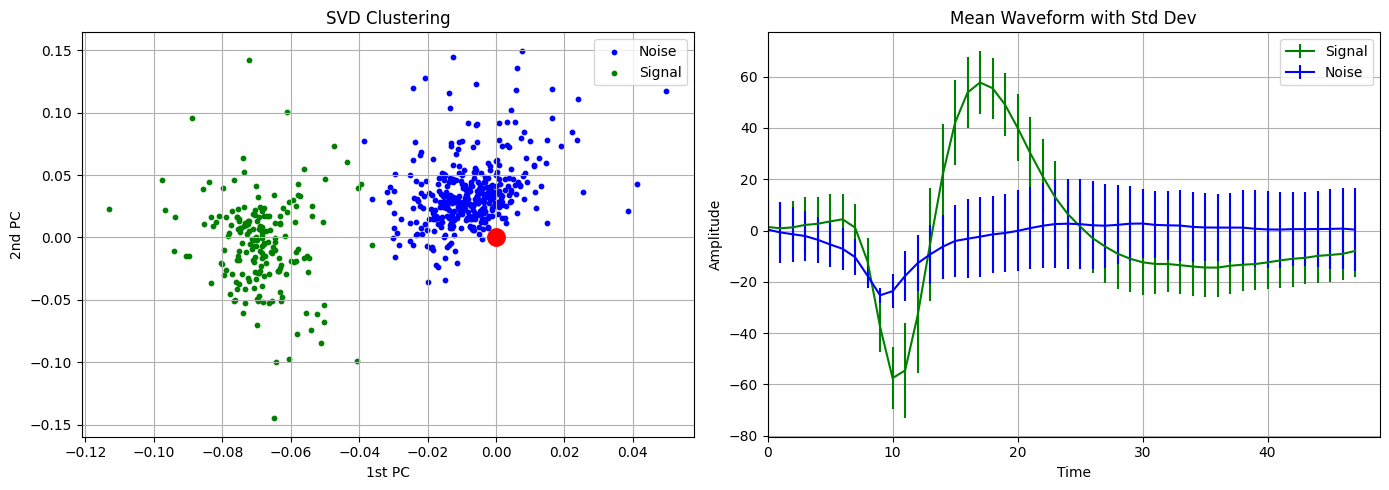

In [ ]:
neuro_data_path = os.path.join(data_root_dir, neuro_root_dir, current_neuro_data)
mat = loadmat(neuro_data_path, struct_as_record=False, squeeze_me=True)
pepANA = mat["pepANA"]
pepANA_clean = matlab_to_python(pepANA)
signal_idx, mean_noise_waveform = analyze_waveform(pepANA_clean, 0, verbose=True)

In [8]:
neuro_data_path

'/home/linux-pc/gh/projects/NeuralNexus/New-Features/Thought-to-Image/V1-Visual-Cortex-Visualization/data/crcns-pvc1/crcns-ringach-data/neurodata/ac1/ac1_u004_000.mat'

In [9]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

(48, 573)

In [10]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0].shape

(573,)

In [11]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][:5]

array([0.4543    , 0.54653333, 0.8413    , 0.89186667, 1.03033333])

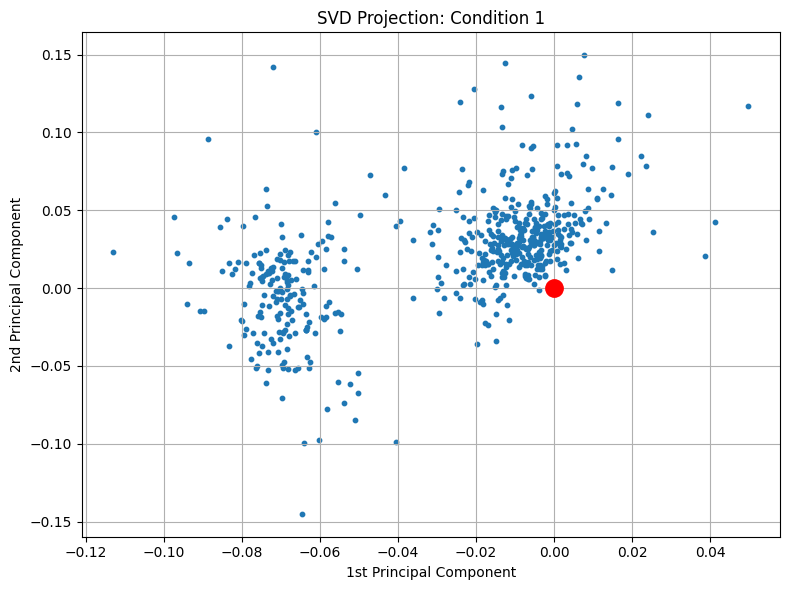

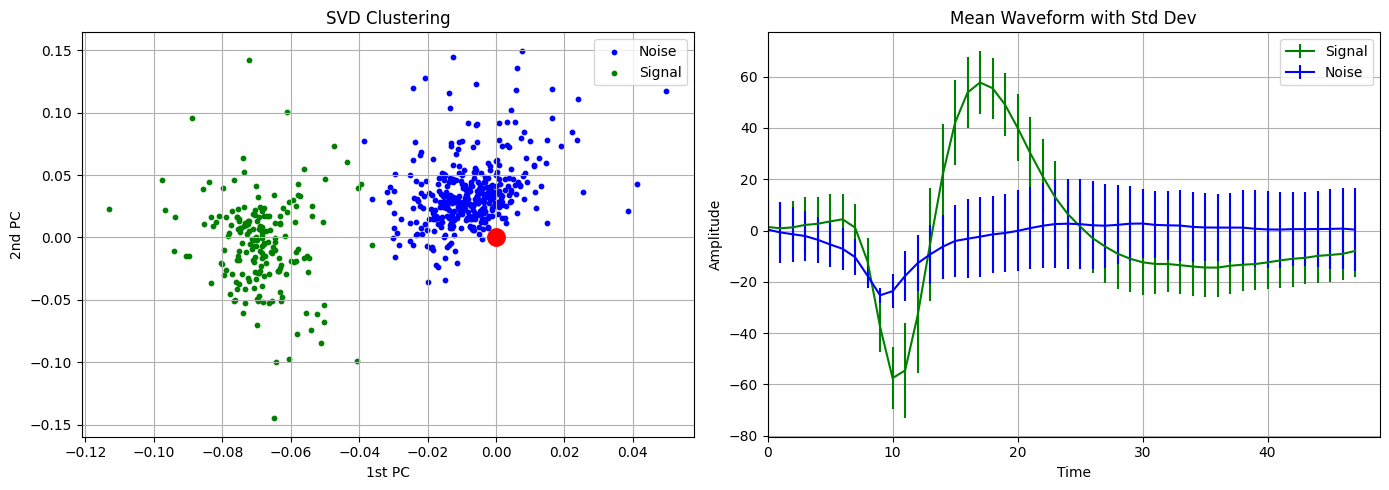

In [ ]:
signal_idx, mean_noise_waveform = analyze_waveform(pepANA_clean, 0, verbose=True)

In [13]:
signal_idx.__len__()

192

In [14]:
# Arrival Times of Detected Signals
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

In [ ]:
# detected_signal_times_for_ch_0 = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

In [15]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

In [59]:
# Waveforms that are 48 samples long that are verifiably signal
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][:, signal_idx].shape

(48, 192)

In [62]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][1][1].shape

# pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][:, signal_idx]

(48, 714)

In [63]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][1][1].shape

(48, 714)

In [50]:
sample_time = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx][0]

In [51]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

In [52]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][1][0]

array([7.66666667e-04, 9.36333333e-02, 1.04700000e-01, 2.12700000e-01,
       2.41000000e-01, 2.54766667e-01, 4.11466667e-01, 4.36866667e-01,
       4.54333333e-01, 5.16800000e-01, 5.20300000e-01, 5.23533333e-01,
       5.86666667e-01, 7.20366667e-01, 9.53466667e-01, 1.03443333e+00,
       1.03693333e+00, 1.04980000e+00, 1.06346667e+00, 1.06763333e+00,
       1.07173333e+00, 1.07943333e+00, 1.09550000e+00, 1.10366667e+00,
       1.10826667e+00, 1.11660000e+00, 1.13713333e+00, 1.15046667e+00,
       1.15866667e+00, 1.16240000e+00, 1.16660000e+00, 1.17180000e+00,
       1.17786667e+00, 1.17980000e+00, 1.18760000e+00, 1.19036667e+00,
       1.21053333e+00, 1.21300000e+00, 1.21726667e+00, 1.21893333e+00,
       1.30453333e+00, 1.35133333e+00, 1.40323333e+00, 1.44250000e+00,
       1.49943333e+00, 1.61746667e+00, 1.62570000e+00, 1.66360000e+00,
       1.70760000e+00, 1.76240000e+00, 1.94116667e+00, 1.97956667e+00,
       2.01243333e+00, 2.06590000e+00, 2.10756667e+00, 2.13760000e+00,
      

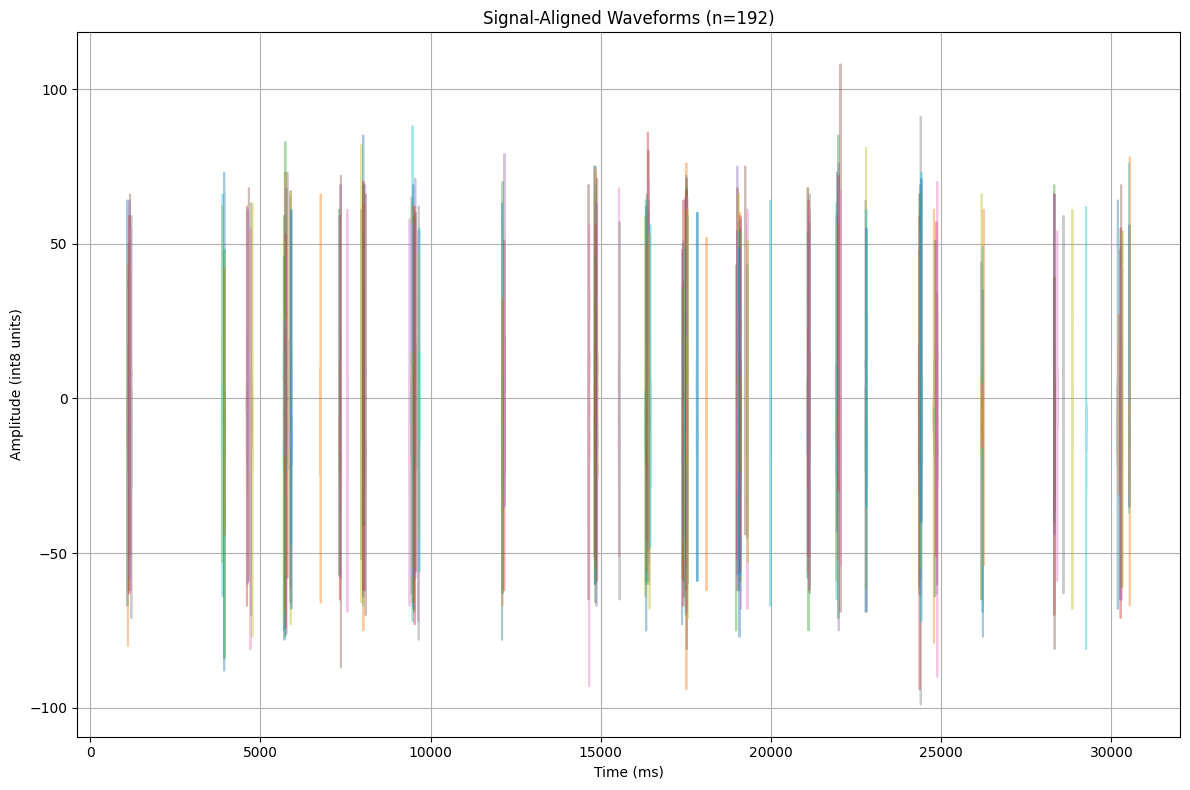

In [32]:
plot_signal_waveforms_aligned(pepANA_clean, 0, signal_idx, electrode=0, sampling_rate=30000.0)

In [33]:
pepANA_clean["listOfResults"][0]["repeat"]["data"]

[[array([ 0.4543    ,  0.54653333,  0.8413    ,  0.89186667,  1.03033333,
          1.04676667,  1.09213333,  1.0955    ,  1.09746667,  1.1127    ,
          1.13403333,  1.1364    ,  1.14606667,  1.15046667,  1.15356667,
          1.16586667,  1.1676    ,  1.17283333,  1.18453333,  1.1907    ,
          1.19573333,  1.20813333,  1.21143333,  1.22073333,  1.24616667,
          1.32046667,  1.75046667,  1.7624    ,  2.01243333,  2.01936667,
          2.67033333,  2.8907    ,  2.9705    ,  3.15436667,  3.20806667,
          3.2501    ,  3.8376    ,  3.8666    ,  3.86956667,  3.87256667,
          3.87496667,  3.88076667,  3.8824    ,  3.88836667,  3.8904    ,
          3.89293333,  3.89586667,  3.93376667,  3.9362    ,  3.93806667,
          3.9412    ,  3.94466667,  3.94906667,  3.95336667,  3.99106667,
          4.12813333,  4.2129    ,  4.32813333,  4.5963    ,  4.609     ,
          4.62863333,  4.63126667,  4.66576667,  4.67966667,  4.68656667,
          4.69513333,  4.70383333,  4.

In [34]:
pepANA_clean["listOfResults"][0]["repeat"]["data"]

[[array([ 0.4543    ,  0.54653333,  0.8413    ,  0.89186667,  1.03033333,
          1.04676667,  1.09213333,  1.0955    ,  1.09746667,  1.1127    ,
          1.13403333,  1.1364    ,  1.14606667,  1.15046667,  1.15356667,
          1.16586667,  1.1676    ,  1.17283333,  1.18453333,  1.1907    ,
          1.19573333,  1.20813333,  1.21143333,  1.22073333,  1.24616667,
          1.32046667,  1.75046667,  1.7624    ,  2.01243333,  2.01936667,
          2.67033333,  2.8907    ,  2.9705    ,  3.15436667,  3.20806667,
          3.2501    ,  3.8376    ,  3.8666    ,  3.86956667,  3.87256667,
          3.87496667,  3.88076667,  3.8824    ,  3.88836667,  3.8904    ,
          3.89293333,  3.89586667,  3.93376667,  3.9362    ,  3.93806667,
          3.9412    ,  3.94466667,  3.94906667,  3.95336667,  3.99106667,
          4.12813333,  4.2129    ,  4.32813333,  4.5963    ,  4.609     ,
          4.62863333,  4.63126667,  4.66576667,  4.67966667,  4.68656667,
          4.69513333,  4.70383333,  4.

In [35]:
# Associating frames with spike signals
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][:, signal_idx]

array([[ 10,  -7,   4, ..., -10,  -6,  -7],
       [ -2,  -4,   7, ...,  -7,  -8, -13],
       [ -8,  -2,   6, ...,   1,  -6, -19],
       ...,
       [-12,  -7, -16, ...,   0,  -1,  -1],
       [-12,   0,  -9, ...,  -1,   2,  -7],
       [ -9,   4,  -7, ...,  -3,   4,  -7]], dtype=int8)

In [36]:
movie_id, segment_id = pepANA_clean["listOfResults"][0]["values"]
movie_id, segment_id
signal_idx

array([  8,   9,  11,  14,  15,  17,  19,  22,  40,  46,  49,  51,  52,
        59,  61,  62,  67,  68,  70,  75,  77,  78,  80,  82,  83,  85,
        90,  92,  93,  94,  95,  99, 101, 105, 107, 109, 114, 119, 123,
       127, 129, 130, 131, 132, 135, 138, 144, 147, 150, 153, 155, 158,
       161, 162, 164, 165, 168, 171, 173, 177, 187, 190, 194, 197, 199,
       216, 221, 224, 229, 234, 236, 238, 239, 241, 243, 246, 248, 250,
       254, 255, 256, 261, 262, 269, 271, 272, 273, 276, 278, 279, 283,
       285, 286, 287, 290, 295, 298, 299, 301, 303, 304, 305, 306, 307,
       308, 309, 313, 315, 316, 325, 326, 328, 334, 339, 340, 341, 342,
       344, 346, 347, 348, 354, 356, 357, 360, 370, 380, 382, 384, 388,
       394, 396, 398, 399, 401, 404, 405, 406, 409, 411, 413, 415, 419,
       423, 425, 428, 432, 436, 437, 438, 440, 450, 454, 456, 459, 461,
       463, 465, 466, 468, 469, 470, 479, 481, 484, 487, 488, 491, 492,
       495, 496, 505, 514, 515, 517, 519, 522, 524, 527, 532, 53

In [37]:
# Time between frames and detected signals
latency = 60e-3
frame_period = 1/30 # Hz

In [38]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]

array([ 0.4543    ,  0.54653333,  0.8413    ,  0.89186667,  1.03033333,
        1.04676667,  1.09213333,  1.0955    ,  1.09746667,  1.1127    ,
        1.13403333,  1.1364    ,  1.14606667,  1.15046667,  1.15356667,
        1.16586667,  1.1676    ,  1.17283333,  1.18453333,  1.1907    ,
        1.19573333,  1.20813333,  1.21143333,  1.22073333,  1.24616667,
        1.32046667,  1.75046667,  1.7624    ,  2.01243333,  2.01936667,
        2.67033333,  2.8907    ,  2.9705    ,  3.15436667,  3.20806667,
        3.2501    ,  3.8376    ,  3.8666    ,  3.86956667,  3.87256667,
        3.87496667,  3.88076667,  3.8824    ,  3.88836667,  3.8904    ,
        3.89293333,  3.89586667,  3.93376667,  3.9362    ,  3.93806667,
        3.9412    ,  3.94466667,  3.94906667,  3.95336667,  3.99106667,
        4.12813333,  4.2129    ,  4.32813333,  4.5963    ,  4.609     ,
        4.62863333,  4.63126667,  4.66576667,  4.67966667,  4.68656667,
        4.69513333,  4.70383333,  4.71063333,  4.7297    ,  4.74

## Identifying the stimulus image

In [39]:
frame_indices = ((pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx] - latency) // frame_period).astype(int)

In [40]:
# Movie_id is 0, 1, 2, or 3; segment_id is greater than 10 less than 100
movie_id, segment_id = pepANA_clean["listOfResults"][0]["values"]

In [41]:
movie_id_zeros_n = (3 - len(str(abs(movie_id))))
movie_id_zeros = repr(0)*movie_id_zeros_n
movie_id_formatted = movie_id_zeros + str(movie_id)

In [42]:
movie_id, segment_id = pepANA_clean["listOfResults"][0]["values"]

In [43]:
segment_id_zeros_n = (3 - len(str(abs(segment_id))))
segment_id_zeros = repr(0)*segment_id_zeros_n
segment_id_formatted =  segment_id_zeros + str(segment_id)

In [44]:
frame_indices_formatted = [str(idx).zfill(3) for idx in frame_indices]

In [45]:
movie_id_formatted

'000'

In [46]:
segment_id_formatted

'000'

In [47]:
movie_frame_str_l = ["movie" + movie_id_formatted + "_" + segment_id_formatted + "_" + frame_indices_formatted_idx + ".jpeg" for frame_indices_formatted_idx in frame_indices_formatted]
movie_frames_root_path = "../data/crcns-pvc1/crcns-ringach-data/movie_frames/"
movie_frame_dir = "movie" + movie_id_formatted + "_" + segment_id_formatted + ".images"
full_image_path_l = [movie_frames_root_path + movie_frame_dir + "/" + movie_frame_str for movie_frame_str in movie_frame_str_l]
full_image_path = full_image_path_l[1] 

In [48]:
192*120

23040

In [49]:
full_image_path_l

['../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_031.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_031.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_032.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_032.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_033.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_033.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_033.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_034.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_114.jpeg',
 '../data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_115.jpeg',
 '../data/crcns-pvc1/crcns-rin

In [67]:
image = cv2.imread(full_image_path, cv2.IMREAD_COLOR)
cv2.imshow("Image", image)
cv2.waitKey(0) 
cv2.destroyAllWindows()

Next Steps:
- [ ] I identify all 16x48 waveforms that are associated with spiking activity of each of the 16 electrodes for all 120 conditions. 
- [ ] I use SVD to detect the signal indices, 
- [ ] collect the movie images, 
- [ ] identify the other 15 electrode waveforms at the spike time of the original electrode, 
- [ ] normalize these waveforms with a per-channel zero mean and unit variance. Then I 
- [ ] define the architecture of a neural network that will generate an image based upon a 16x48 waveform input. Then I 
- [ ] iterate through the 16x48 waveforms that I have and 
- [ ] Create a Train and test dataset for the neural network
- [ ] Train the neural network
- [ ] iterate through the 16x48 waveforms that I have randomly
- [ ] send the 16x48 waveforms through a websocket endpoint to a relay 
- [ ] generate an image in the relay using the trained neural network
- [ ] Visualize the image in a react frontend.


## identify all 16x48 waveforms that are associated with spiking activity of each of the 16 electrodes for all 120 conditions. 

I need to preallocate an array that is Nx16x48 where N is the number of detected spikes. Then for each channel I need to identify if there is a matching spike on another channel by using the detected spike times of the original channel to search the other arrays. If there is a detected starting time then I need to extract the 48 samples from that starting time and populate the array with those samples at the corresponding signal in the initial detected electrode. All non-detected times will be set to zero so the pre-allocation must be initialized to zero. 

Then I will iterate to the next electrode for all 16 electrodes and use SVD to detect spike times and the corresponding stimulus images list. Then I will perform the same function as defined above:

I need to preallocate an array that is Nx16x48 where N is the number of detected spikes. Then for each channel I need to identify if there is a matching spike on another channel by using the detected spike times of the original channel to search the other arrays. If there is a detected starting time then I need to extract the 48 samples from that starting time and populate the array with those samples at the corresponding signal in the initial detected electrode. All non-detected times will be set to zero so the pre-allocation must be initialized to zero. 

Then I will move to the next condition and perform this operation for all 120 conditions identifying all Nx16x48 waveform samples and N stimulus images for 16 electrodes for all 120 conditions. I will save the 16xNx16x48 Numpy array and the 16xN list of images for all 120 electrodes where N is the number of detected signals and corresponding stimulus images. 

Each 16x48 sample is only representative of a single electrode that is associated with the image. I have N samples for the single electrode for all 16 electrodes. I need to train the model such that the features that each electrode responds to are captured by the model such that when I have 16 arbitrary waveforms of 48 samples long, the resulting image is correspondent to the features that stimulated those electrodes initially. I do not want to train the model such that there are 1 stimulus electrode and 15 noise or zero value electrodes and then send a sample that only generates the single feature. I want to send a signal that comprises all electrodes and generates the corresponding image as a result. The other channels may be noise, but I dont want to train the model to detect only a single channel. I want the model to capture the features that each channel corresponds to in the stimulus image. 

Use SVD on the other channels. Capture the mean noise signal. This will be used as a placeholder for signals that are non-present.


In [72]:
neuro_data_path = os.path.join(data_root_dir, neuro_root_dir, current_neuro_data)
mat = loadmat(neuro_data_path, struct_as_record=False, squeeze_me=True)
pepANA = mat["pepANA"]
pepANA_clean = matlab_to_python(pepANA)

In [73]:
type(pepANA_clean)

dict

In [79]:
signal_idx_l, mean_noise_waveforms = collect_mean_noise_waveforms_and_signal_indices(pepANA_clean, verbose=False)

In [ ]:
# 16 x (signal_idx_l.__len__()) x 16 x 48;
# Identify the times 

In [239]:
arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]

In [243]:
for time in spike_times_to_id:
    # find index of `time` in the time array of electrode i
    time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]
    # find index where time matches exactly
    time_indices = np.where(time_arr == time)[0]

    if time_indices.size > 0:
        time_index = time_indices[0]  # take first match
        waveform = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][time_index].flatten()
        # use waveform as needed

In [ ]:
# Important
# for each electrode, identify all the stimulus spikes and the waveforms for the other 15 electrodes at the stimulus spike times. If the waveforms are not found, use the mean noise waveform.
collected_stimulus_waveforms_from_all_electrodes_l = []
for init_electrode in range(16):
    spike_times_to_id = pepANA_clean["listOfResults"][0]["repeat"]["data"][init_electrode][0][signal_idx_l[init_electrode]]
    collected_stimulus_waveforms_from_all_electrodes = np.zeros((len(spike_times_to_id), 16, 48))
    time_idx = 0
    for time in spike_times_to_id:
        for i in range(16):
            if i == init_electrode:
                for time in spike_times_to_id:
                    # find index of `time` in the time array of electrode i
                    time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]
                    # find index where time matches exactly
                    time_indices = np.where(time_arr == time)[0]

                    if time_indices.size > 0:
                        time_index = time_indices[0]  # take first match
                        waveform = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][:, time_index].flatten()
                        collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = waveform
            time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]
            temporal_index = np.nonzero(np.isin(time_arr, time))[0]
            if len(temporal_index) > 0:
                waveform = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][:, temporal_index].flatten()
                collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = waveform
            else:
                collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = mean_noise_waveforms[i]
        time_idx +=1 
    collected_stimulus_waveforms_from_all_electrodes_l.append(collected_stimulus_waveforms_from_all_electrodes)

In [ ]:
asdf 
# continue

IndexError: list index out of range

In [248]:
spike_times_to_id.shape

(200,)

In [246]:
collected_stimulus_waveforms_from_all_electrodes.shape

(200, 16, 48)

In [167]:
collected_stimulus_waveforms_from_all_electrodes.shape

(192, 16, 48)

In [179]:
mean_noise_waveforms.shape

(16, 48)

In [216]:
# Identifying times of signal spikes
init_electrode = 0
spike_times_to_id = pepANA_clean["listOfResults"][0]["repeat"]["data"][init_electrode][0][signal_idx_l[init_electrode]]
collected_stimulus_waveforms_from_all_electrodes = np.zeros((len(spike_times_to_id), 16, 48))
time_idx = 0
time = 0
spike_times_to_id[0]
i = 1
time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]
temporal_index = np.nonzero(np.isin(time_arr, test_time))[0]


In [217]:
temporal_index.__len__()

1

In [218]:
temporal_index[0]

0

In [222]:
temporal_index

array([0])

In [227]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][:, temporal_index].flatten()

array([ -1,  -1,   2,  -1,  -9, -15, -12,  -4, -15, -24, -19, -23, -17,
       -10,  -7,  -4,  -4,  -3,  -1,   0,   6,  11,   4,  -5,  -1,   2,
        -2,  -5,  -2,   2,   3,   5,   3,   4,  10,   8,  11,  11,   4,
         2,  -1,  -5,   0,  -4,  -5,   7,  10,   7], dtype=int8)

In [215]:
mean_noise_waveforms[i]

array([ 1.17274168e-01, -2.59904913e-01, -6.03803487e-01, -1.54992076e+00,
       -3.25356577e+00, -4.90491284e+00, -5.82567353e+00, -9.14104596e+00,
       -1.78050713e+01, -2.58890650e+01, -2.18399366e+01, -1.38858954e+01,
       -9.04437401e+00, -6.55625990e+00, -4.57369255e+00, -2.64500792e+00,
       -1.09984152e+00, -5.45166403e-01, -1.37876387e-01,  3.59746434e-01,
        8.92234548e-01,  8.51030111e-01,  3.59746434e-01,  2.53565769e-02,
       -1.47385103e-01, -1.55309033e-01, -1.90174326e-02,  3.39144216e-01,
        7.11568938e-01,  7.46434231e-01,  6.06973059e-01,  6.97305864e-02,
       -3.80348653e-01, -2.85261490e-01, -1.83835182e-01, -2.59904913e-01,
       -1.36291601e-01, -4.27892235e-02, -2.97939778e-01, -3.96196513e-02,
        1.09350238e-01,  1.03011094e-01, -3.64500792e-02, -9.98415214e-02,
       -6.81458003e-02,  4.29477021e-01,  5.83201268e-01,  7.76545166e-01])

In [209]:
if len(temporal_index) > 0:
    print("true")
else:
    print("false")

false


In [231]:
time_idx = 0

collected_stimulus_waveforms_from_all_electrodes[time_idx][0]
for time in spike_times_to_id:
    for i in range(16):
        if i == init_electrode:
            collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][:, time_idx]
            continue
        time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]
        temporal_index = np.nonzero(np.isin(time_arr, time))[0]
        if len(temporal_index) > 0:
            waveform = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][:, temporal_index].flatten()
            collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = waveform
        else:
            collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = mean_noise_waveforms[i]
    time_idx +=1 

In [234]:
collected_stimulus_waveforms_from_all_electrodes[0]

array([[ 0.00000000e+00, -1.00000000e+00,  3.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         0.00000000e+00, -9.00000000e+00, -1.90000000e+01,
        -2.40000000e+01, -1.60000000e+01, -1.10000000e+01,
        -1.70000000e+01, -1.40000000e+01, -9.00000000e+00,
         1.00000000e+00, -3.00000000e+00, -7.00000000e+00,
         0.00000000e+00,  2.00000000e+00, -1.00000000e+00,
        -3.00000000e+00,  0.00000000e+00,  9.00000000e+00,
         9.00000000e+00,  5.00000000e+00,  4.00000000e+00,
         1.00000000e+00, -6.00000000e+00, -7.00000000e+00,
        -4.00000000e+00, -3.00000000e+00, -8.00000000e+00,
        -9.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -5.00000000e+00,  0.00000000e+00,  3.00000000e+00,
         1.00000000e+00,  3.00000000e+00,  8.00000000e+00,
         5.00000000e+00,  4.00000000e+00,  7.00000000e+00,
         1.30000000e+01,  1.50000000e+01,  7.00000000e+00],
       [ 1.17274168e-01, -2.59904913e-01, -6.03803487e-

In [ ]:
# Identifying times of signal spikes
init_electrode = 0
spike_times_to_id = pepANA_clean["listOfResults"][0]["repeat"]["data"][init_electrode][0][signal_idx_l[init_electrode]]
collected_stimulus_waveforms_from_all_electrodes = np.zeros((len(spike_times_to_id), 16, 48))
time_idx = 0
for time in spike_times_to_id:
    for i in range(16):
        if i == init_electrode:
            continue
        time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]
        temporal_index = np.nonzero(np.isin(time_arr, time))[0]

        if temporal_index:
            waveform = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][1][temporal_index]
            collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = waveform
        else:
            collected_stimulus_waveforms_from_all_electrodes[time_idx][i] = mean_noise_waveforms[i]
    time_idx +=1 

/tmp/ipykernel_15415/298191654.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if temporal_index:


IndexError: index 139 is out of bounds for axis 0 with size 48

In [169]:
for i in range(16):
    if i == init_electrode:
        continue
    time_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][i][0]

In [170]:
time_arr[:2]

array([0.19223333, 0.36576667])

In [171]:
values = time_arr[:2]
indices = np.nonzero(np.isin(time_arr, values))[0]


In [172]:
indices

array([0, 1])

In [173]:
time_arr[indices]

array([0.19223333, 0.36576667])

In [174]:
indices

array([0, 1])

In [175]:
signal_idx_l, mean_noise_waveforms = collect_mean_noise_waveforms_and_signal_indices(pepANA_clean, verbose=False)

In [176]:
values

array([0.19223333, 0.36576667])

In [177]:
time_arr[values]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
np.where(np.abs(time_arr - spike_times_to_id) == 0)

ValueError: operands could not be broadcast together with shapes (298,) (192,) 

In [ ]:
spike_times_to_id

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

In [ ]:
spike_times_to_id.__len__()

192

In [ ]:
import numpy as np

def find_value_in_other_channels(pepANA_clean, i, target_value, tolerance=1e-10):
    """
    Searches for a target value in all channels except index i.

    Args:
        pepANA_clean (dict): Data dictionary.
        i (int): Index to exclude.
        target_value (float): Value to find.
        tolerance (float): Tolerance for float comparison.

    Returns:
        list: A list of 15 elements. Each element is an array of indices where the value is found,
              or None if not found. Channels are ordered by index, skipping i.
    """
    repeat_data = pepANA_clean["listOfResults"][0]["repeat"]["data"]
    results = []

    for idx in range(16):
        if idx == i:
            continue

        arr = repeat_data[idx][0]
        arr = np.asarray(arr)

        match_indices = np.where(np.abs(arr - target_value) < tolerance)[0]

        if match_indices.size > 0:
            results.append(match_indices)
        else:
            results.append(None)

    return results


In [ ]:
electrode

0

In [ ]:
arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][1][0]

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx_l[0]]

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

array([], dtype=int64)

In [ ]:
# for time in signal_idx_l:
time = 0
signal_idx_in_other_electrodes = find_value_in_other_channels(pepANA_clean, i=electrode, target_value=signal_idx_l[time], tolerance=0)


ValueError: operands could not be broadcast together with shapes (714,) (192,) 

In [ ]:
spike_times_to_id[0]

1.0974666666666666

In [ ]:
# for electrode not equal to the original electrode, find all times matching spike_times_to_id. if not present, then 

pepANA_clean["listOfResults"][0]["repeat"]["data"][1][0]

array([7.66666667e-04, 9.36333333e-02, 1.04700000e-01, 2.12700000e-01,
       2.41000000e-01, 2.54766667e-01, 4.11466667e-01, 4.36866667e-01,
       4.54333333e-01, 5.16800000e-01, 5.20300000e-01, 5.23533333e-01,
       5.86666667e-01, 7.20366667e-01, 9.53466667e-01, 1.03443333e+00,
       1.03693333e+00, 1.04980000e+00, 1.06346667e+00, 1.06763333e+00,
       1.07173333e+00, 1.07943333e+00, 1.09550000e+00, 1.10366667e+00,
       1.10826667e+00, 1.11660000e+00, 1.13713333e+00, 1.15046667e+00,
       1.15866667e+00, 1.16240000e+00, 1.16660000e+00, 1.17180000e+00,
       1.17786667e+00, 1.17980000e+00, 1.18760000e+00, 1.19036667e+00,
       1.21053333e+00, 1.21300000e+00, 1.21726667e+00, 1.21893333e+00,
       1.30453333e+00, 1.35133333e+00, 1.40323333e+00, 1.44250000e+00,
       1.49943333e+00, 1.61746667e+00, 1.62570000e+00, 1.66360000e+00,
       1.70760000e+00, 1.76240000e+00, 1.94116667e+00, 1.97956667e+00,
       2.01243333e+00, 2.06590000e+00, 2.10756667e+00, 2.13760000e+00,
      

In [ ]:
spike_times_to_id

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

In [ ]:

signal_idx, mean_noise_waveform = analyze_waveform(pepANA_clean, 0, verbose=True)
detected_signal_times_for_ch_0 = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

In [ ]:
mean_noise_waveform

array([  0.38057743,  -0.71653543,  -1.43832021,  -2.14173228,
        -3.59055118,  -5.42257218,  -7.11811024, -10.37532808,
       -17.64304462, -25.23884514, -23.64829396, -17.7191601 ,
       -12.7664042 ,  -9.33070866,  -6.33595801,  -4.07349081,
        -3.19685039,  -2.39370079,  -1.50656168,  -0.96062992,
        -0.14173228,   0.92650919,   1.8503937 ,   2.52493438,
         2.66141732,   2.49868766,   2.04724409,   1.88188976,
         2.21784777,   2.65879265,   2.73228346,   2.20734908,
         2.02887139,   1.93700787,   1.42519685,   1.19160105,
         1.14698163,   1.13910761,   1.13385827,   0.69553806,
         0.42782152,   0.37532808,   0.54330709,   0.53805774,
         0.58792651,   0.61417323,   0.74278215,   0.35695538])

In [ ]:
detected_signal_times_for_ch_0 = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

In [ ]:
detected_signal_times_for_ch_0[0]

1.0974666666666666

In [ ]:
test_arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][1][0][:2]

In [ ]:
import numpy as np

# Your array
arr = pepANA_clean["listOfResults"][0]["repeat"]["data"][1][0]

# Values you want to find
target_values = np.array([7.66666667e-04])

# Use broadcasting + np.isclose to find indices of all approximate matches
tolerance = 1e-10
matches = np.isclose(arr[:, None], target_values[None, :], atol=tolerance)

# Get the indices in `arr` where any of the values match
matching_indices = np.where(matches.any(axis=1))[0]

print("Matching indices:", matching_indices)


Matching indices: [0]


In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][1][0]

array([7.66666667e-04, 9.36333333e-02, 1.04700000e-01, 2.12700000e-01,
       2.41000000e-01, 2.54766667e-01, 4.11466667e-01, 4.36866667e-01,
       4.54333333e-01, 5.16800000e-01, 5.20300000e-01, 5.23533333e-01,
       5.86666667e-01, 7.20366667e-01, 9.53466667e-01, 1.03443333e+00,
       1.03693333e+00, 1.04980000e+00, 1.06346667e+00, 1.06763333e+00,
       1.07173333e+00, 1.07943333e+00, 1.09550000e+00, 1.10366667e+00,
       1.10826667e+00, 1.11660000e+00, 1.13713333e+00, 1.15046667e+00,
       1.15866667e+00, 1.16240000e+00, 1.16660000e+00, 1.17180000e+00,
       1.17786667e+00, 1.17980000e+00, 1.18760000e+00, 1.19036667e+00,
       1.21053333e+00, 1.21300000e+00, 1.21726667e+00, 1.21893333e+00,
       1.30453333e+00, 1.35133333e+00, 1.40323333e+00, 1.44250000e+00,
       1.49943333e+00, 1.61746667e+00, 1.62570000e+00, 1.66360000e+00,
       1.70760000e+00, 1.76240000e+00, 1.94116667e+00, 1.97956667e+00,
       2.01243333e+00, 2.06590000e+00, 2.10756667e+00, 2.13760000e+00,
      

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][1][1][:, 0]

array([ -1,  -1,   2,  -1,  -9, -15, -12,  -4, -15, -24, -19, -23, -17,
       -10,  -7,  -4,  -4,  -3,  -1,   0,   6,  11,   4,  -5,  -1,   2,
        -2,  -5,  -2,   2,   3,   5,   3,   4,  10,   8,  11,  11,   4,
         2,  -1,  -5,   0,  -4,  -5,   7,  10,   7], dtype=int8)

In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx].shape

(192,)